In [26]:

# Pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# No warnings about setting value on copy of slice
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', 60)

# Matplotlib for visualization
import matplotlib.pyplot as plt
%matplotlib inline

# Set default font size
plt.rcParams['font.size'] = 24

from IPython.core.pylabtools import figsize

# Seaborn for visualization
import seaborn as sns

sns.set(font_scale = 2)

# Imputing missing values
from sklearn.preprocessing import Imputer, MinMaxScaler

# Machine Learning Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor

from sklearn import tree

# LIME for explaining predictions
import lime 
import lime.lime_tabular

In [27]:
# Read in data into dataframes 
train_features = pd.read_csv('training_features.csv')
test_features = pd.read_csv('testing_features.csv')
train_labels = pd.read_csv('training_labels.csv')
test_labels = pd.read_csv('testing_labels.csv')

In [30]:

# Create an imputer object with a median filling strategy
imputer = Imputer(strategy='median')

# Train on the training features
imputer.fit(train_features)
# Transform both training data and testing data
X = imputer.transform(train_features)
X_test = imputer.transform(test_features)
# Sklearn wants the labels as one-dimensional vectors
y = np.array(train_labels).reshape((-1,))
y_test = np.array(test_labels).reshape((-1,))

/home/venkat/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [31]:
import pickle
filename='final_model.sav'
final_model=pickle.load(open(filename,'rb'))

In [32]:
# Function to calculate mean absolute error
def mae(y_true, y_pred):
    return np.mean(abs(y_true - y_pred))

final_model.fit(X,y)
model_pred=final_model.predict(X_test)

print('Final Model Performance on the test set: MAE = %0.4f' % mae(y_test, model_pred))

Final Model Performance on the test set: MAE = 9.1226


## Model interpretation

In [39]:

# Extract the feature importances into a dataframe
feature_results = pd.DataFrame({'feature': list(train_features.columns), 
                                'importance': final_model.feature_importances_})

# Show the top 10 most important
feature_results = feature_results.sort_values('importance', ascending = False).reset_index(drop=True)
feature_results.head(5)

,feature,importance
0,Site EUI (kBtu/ft²),0.664533
1,Weather Normalized Site Electricity Intensity ...,0.145655
2,Largest Property Use Type_Multifamily Housing,0.080936
3,Property Id,0.016546
4,Largest Property Use Type_Non-Refrigerated War...,0.012240


Text(0.5,1,'feature importance')

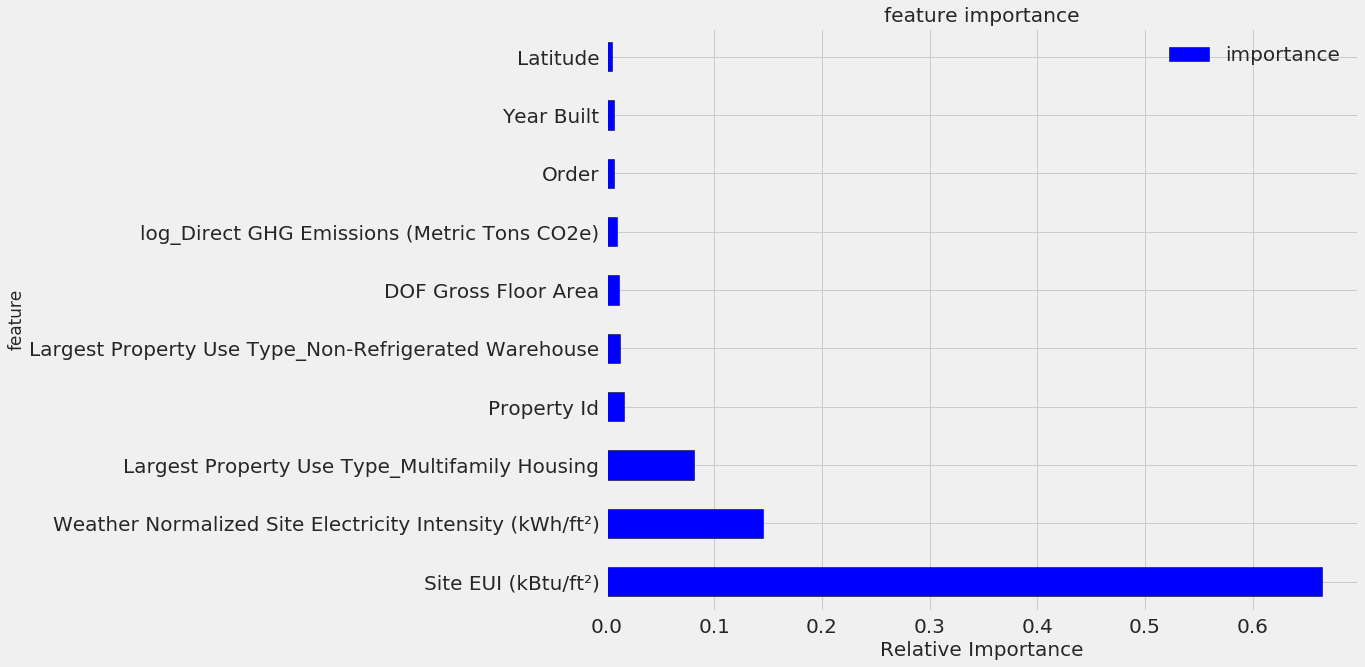

In [48]:
figsize(12,10)

plt.style.use('fivethirtyeight')
feature_results.iloc[:10,:].plot(x='feature',y='importance',kind='barh',color='blue',edgecolor='black')
plt.xlabel('Relative Importance',size=20)
plt.title('feature importance')

In [56]:
#using feature importance for feature selection
most_important_features=feature_results['feature'][:10]
#finding index that corresponds to that feature
indices=[list(train_features.columns).index(x) for x in most_important_features]
#keep only the most important features
X_reduced=X[:,indices]
X_test_reduced=X_test[:,indices]


print('Most important training features shape: ', X_reduced.shape)
print('Most important testing  features shape: ', X_test_reduced.shape)

Most important training features shape:  (6622, 10)
Most important testing  features shape:  (2839, 10)


In [58]:
lr = LinearRegression()

# Fit on full set of features
lr.fit(X, y)
lr_full_pred = lr.predict(X_test)

# Fit on reduced set of features
lr.fit(X_reduced, y)
lr_reduced_pred = lr.predict(X_test_reduced)

# Display results
print('Linear Regression Full Results: MAE =    %0.4f.' % mae(y_test, lr_full_pred))
print('Linear Regression Reduced Results: MAE = %0.4f.' % mae(y_test, lr_reduced_pred))

Linear Regression Full Results: MAE =    13.4651.
Linear Regression Reduced Results: MAE = 14.3359.


In [60]:
# Create the model with the same hyperparamters
model_reduced = GradientBoostingRegressor(loss='lad', max_depth=5, max_features=None,
                                  min_samples_leaf=6, min_samples_split=6, 
                                  n_estimators=800, random_state=42)

# Fit and test on the reduced set of features
model_reduced.fit(X_reduced, y)
model_reduced_pred = model_reduced.predict(X_test_reduced)

print('Gradient Boosted Reduced Results: MAE = %0.4f' % mae(y_test, model_reduced_pred))

#we can see reduced features actually increase error thus reducing predicting power hence we will keep all features

Gradient Boosted Reduced Results: MAE = 9.4775


## Locally Interpretable Model-agnostic Explanations (LIME)

In [92]:
#using reduced model trading off accuracy for interpretability
residuals=abs(model_reduced_pred-y_test)
wrong=X_test_reduced[np.argmax(residuals),:]
right=X_test_reduced[np.argmin(residuals),:]

In [93]:
#creating a lime explainer object
explainer=lime.lime_tabular.LimeTabularExplainer(training_data=X_reduced,mode='regression',training_labels=y,
                                                feature_names=list(most_important_features))

Prediction: 89.4412
Actual Value: 4.0000


/home/venkat/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number2.402749e-27
  overwrite_a=True).T


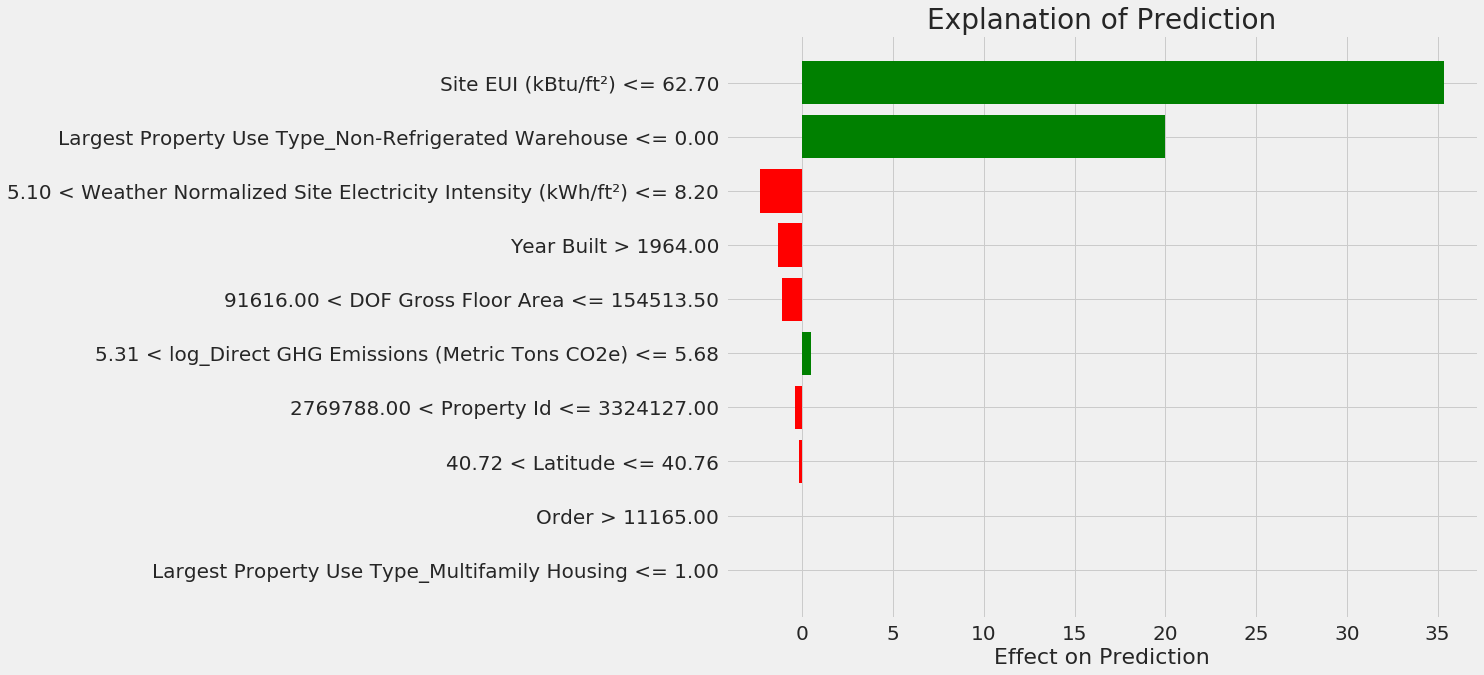

In [97]:
print('Prediction: %0.4f' % model_reduced.predict(wrong.reshape(1, -1)))

print('Actual Value: %0.4f' % y_test[np.argmax(residuals)])
#explanation
wrong_exp=explainer.explain_instance(data_row=wrong,predict_fn=model_reduced.predict)
wrong_exp.as_pyplot_figure()

plt.title('Explanation of Prediction', size = 28);
plt.xlabel('Effect on Prediction', size = 22);
#high site eui for the row caused more score

In [98]:
wrong_exp.show_in_notebook(show_predicted_value=False)

Prediction: 100.0000
Actual Value: 100.0000


/home/venkat/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number3.733091e-27
  overwrite_a=True).T


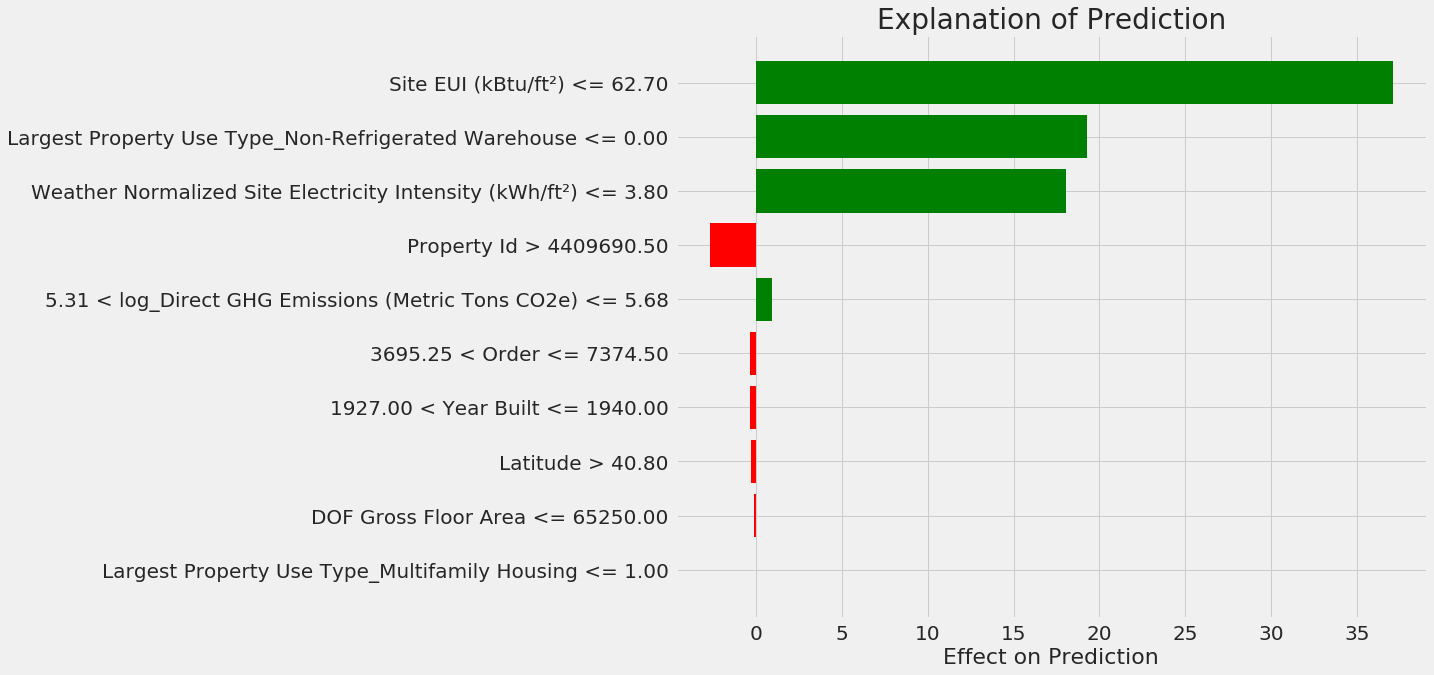

In [99]:

# Display the predicted and true value for the right instance
print('Prediction: %0.4f' % model_reduced.predict(right.reshape(1, -1)))
print('Actual Value: %0.4f' % y_test[np.argmin(residuals)])

# Explanation for wrong prediction
right_exp = explainer.explain_instance(right, model_reduced.predict, num_features=10)
right_exp.as_pyplot_figure();
plt.title('Explanation of Prediction', size = 28);
plt.xlabel('Effect on Prediction', size = 22);

In [100]:
right_exp.show_in_notebook(show_predicted_value=False)

## Examining single decision tree

In [109]:
#extracting a single tree
single_tree=model_reduced.estimators_[105][0]
tree.export_graphviz(single_tree, out_file = 'tree.dot',
                     rounded = True, 
                     feature_names = most_important_features,
                     filled = True)
tree.export_graphviz(single_tree, out_file = 'tree_small.dot',
                     rounded = True, feature_names = most_important_features,
                     filled = True, max_depth = 3)

In [111]:
#Convert to a png from the command line
!dot -Tpng tree_small.dot -o tree_small.png

In [ ]:
#see the tree in folder

## Make Conclusions and Document Findings



The final part of the machine learning pipeline might be the most important: we need to compress everything we have learned into a short summary highlighting only the most crucial findings. Personally, I have difficulty avoiding explaining all the technical details because I enjoy all the work. However, the person you're presenting to probably doesn't have much time to listen to all the details and just wants to hear the takeaways. Learning to extract the most important elements of data science or machine learning project is a crucial skill, because if our results aren't understood by others, then they will never be used!

I encourage you to come up with your own set of conclusions, but here are my top 2 designed to be communicated in 30 seconds:

Using the given building energy data, a machine learning model can predict the Energy Star Score of a building to within 10 points.
The most important variables for determining the Energy Star Score are the Energy Use Intensity, Electricity Use Intensity, and the Water Use Intensity
If anyone asks for the details, then we can easily explain all the implementation steps, and present our (hopefully) well-documented work. Another crucial aspect of a machine learning project is that you have commented all your code and made it easy to follow! You want someone else (or yourself in a few months) to be able to look at your work and completely understand the decisions you made. Ideally you should write code with the intention that it will be used again. Even when we are doing projects by ourselves, it's good to practice proper documentation and it will make your life much easier when you want to revisit a project.